In [31]:
%reset -f

import numpy as np
import math
import matplotlib.pyplot as plt
from casadi import *
from dataclasses import dataclass

In [75]:


@dataclass
class Parameters:
    # Time and discretization
    tf: float = 40                  # final time [sec]
    nu: float = 20                  # number of control intervals
    dut: float = tf / nu            # time step

    # Aircraft physical constants
    m: float = 4662                # mass [lb sec^2 / ft]
    g: float = 32.172              # gravity [ft/sec^2]
    delta: float = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0: float = 0.4456e5           # [lb]
    A1: float = -0.2398e2          # [lb sec / ft]
    A2: float = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho: float = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S: float = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0: float = 0.4             # initial beta value (approximate)
    beta_dot0: float = 0.2         # initial beta rate
    sigma: float = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0: float = 0.1552
    B1: float = 0.12369            # [1/rad]
    B2: float = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0: float = 0.7125             # baseline lift coefficient
    C1: float = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2: float = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax: float = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax: float = 0.3          # max angle of attack [rad]
    alpha_star: float = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a: float = 6e-8                 # x transition midpoint [ft]
    b: float = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c: float = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d: float = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e: float = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR: float = 1000               # reference altitude [ft]
    h_star: float = 1000           # used in some wind models

    # Auxiliary
    eps: float = 1e-6              # to avoid division by zero in V

    # objective
    q: int = 4


params = Parameters()


def solve_ocp(k_value):
    # State, Time and Control
    x1 = MX.sym('x1')       # x
    x2 = MX.sym('x2')       # h
    x3 = MX.sym('x3')       # V
    x4 = MX.sym('x4')       # gamma
    x5 = MX.sym('x5')       # alpha
    t = MX.sym('t')         # time
    u = MX.sym('u')         # control
    x = vertcat(x1,x2,x3,x4,x5)   
    
    # Wind
    A1 = -50 + params.a * x1**3 + params.b * x1**4
    A2 = 0.025 * (x1 - 2300)
    A3 = 50 - params.a * (4600 - x1)**3 - params.b * (4600 - x1)**4
    A4 = 50 
    A = if_else(x1 <= 500, A1,
        if_else(x1 <= 4100, A2,
        if_else(x1 <= 4600, A3, A4)))
    A_piecewise = Function('A_piecewise', [x1], [A])
    
    B1 = params.d * x1**3 + params.e * x1**4
    B2 = -51 * exp(fmin(-params.c * (x1 - 2300)**4, 30))
    B3 = params.d * (4600 - x1)**3 + params.e * (4600 - x1)**4
    B4 = 0
    B = if_else(x1 <= 500, B1,
        if_else(x1 <= 4100, B2,
        if_else(x1 <= 4600, B3, B4)))
    B_piecewise = Function('B_piecewise', [x1], [B])
    
    wind_x_expr = k_value * A
    wind_x = Function('wind_x', [x1], [wind_x_expr])
    wind_h_expr = k_value * x2 * B / params.h_star
    wind_h = Function('wind_h', [x1, x2], [wind_h_expr])
    
    dWx_dx = Function("dWx_dx", [x1], [gradient(wind_x_expr, x1)])
    dWh_dx = Function("dWh_dx", [x1, x2], [gradient(wind_h_expr, x1)])
    dWh_dh = Function("dWh_dh", [x1, x2], [gradient(wind_h_expr, x2)])
    
    # Other functions
    C_L = if_else(x5 > params.alpha_star, params.C0 +params.C1 * x5, 
                       params.C0 + params.C1 * x5 + params.C2 * (x5 - params.alpha_star)**2)
    
    beta = if_else(t < params.sigma, 
                        params.beta0 + params.beta_dot0 * t, 1.0)
    
    T = beta * (params.A0 + params.A1 * x3 + params.A2 * x3**2)
    
    D = 0.5 * (params.B0 + params.B1 * x5 + params.B2 * x5**2) * params.rho * params.S * x3**2

    L = 0.5 * params.rho * params.S * C_L * x3**2
    
    # ode
    x1dot = x3 * cos(x4) + wind_x(x1)
    x2dot = x3 * sin(x4) + wind_h(x1,x2)
    
    wxdot = dWx_dx(x1) * x1dot
    whdot = dWh_dx(x1,x2) * x1dot + dWh_dh(x1,x2) * x2dot
    x3_safe = fmax(x3, 1e-3)
    
    x3dot = T / params.m * cos(x5 + params.delta) - D / params.m - params.g * sin(x4) - (wxdot * cos(x4) + whdot * sin(x4))
    x4dot = T / (params.m * x3) * sin(x5 + params.delta) + L / (params.m * x3) - params.g / x3_safe * cos(x4) + (1 / x3_safe) * (wxdot * sin(x4) - whdot * cos(x4))
    x5dot = u
    
    f = Function('f', [x, u, t], [vertcat(x1dot, x2dot, x3dot, x4dot, x5dot)])
    
    x2dotdot_expr = x3dot*sin(x4) + x3*x4dot*cos(x4) + whdot
    x2dotdot = Function('x2dotdot', [x, u, t], [x2dotdot_expr])
    
    # objective function
    Q = (params.hR-x2)**params.q
    qf = Function('qf', [x], [Q])
    
    # Integration
    def rk4_step(xk, uk, tk, dt, qk):
        k1 = f(xk, uk, tk)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
        k4 = f(xk + dt * k3, uk, tk + dt)
        qk1 = qf(xk)
        qk2 = qf(xk + dt/2 * k1)
        qk3 = qf(xk + dt/2 * k2)
        qk4 = qf(xk + dt * k3)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4), qk + dt/6 * (qk1 + 2*qk2 + 2*qk3 + qk4)
    
    # npl prep
    w = []    # List of decision variables
    w0 = []   # Initial guess
    lbw = []  # Lower bounds
    ubw = []  # Upper bounds
    g = []    # Constraints
    lbg = []  # Lower bound on constraints
    ubg = []  # Upper bound on constraints
    J = 0     # Objective function    
    
    # initial condition
    x_initial = [0, 600, 239.7, -2.249*pi/180, 7.353*pi/180]
    Xk = MX.sym('X_0', 5)
    w += [Xk]
    lbw += x_initial
    ubw += x_initial
    w0 += x_initial    
 
    Tk = 0
    
    # npl set up
    for k in range(params.nu):
        # control
        Uk = MX.sym('U_' + str(k))
        w += [Uk]
        lbw += [-3*pi/180]
        ubw += [3*pi/180]
        w0 += [0]
        
        # state integration
        Xk_end, J_end = rk4_step(Xk, Uk, Tk, params.dut, J)
        J = J_end
        h_ddot_val = x2dotdot(Xk, Uk, Tk)
        
        Tk += params.dut
        
        # state
        Xk = MX.sym('X_' + str(k+1), 5)
        w += [Xk]
        lbw += [-inf, 0, -inf, -inf, -inf]
        ubw += [inf, params.hR, inf, inf, 17.2*pi/180]
        w0 += [k*10000/params.nu, 600, 239.7, -2.249*pi/180, 7.353*pi/180]
        g+= [Xk_end-Xk]
        lbg += [0, 0, 0, 0, 0]
        ubg += [0, 0, 0, 0, 0]
        
        # Add to constraint list
        g += [h_ddot_val]
        lbg += [-2 * params.g]
        ubg += [10 * params.g]
    
    XF = 7.431*pi/180
    g += [Xk[4] - XF]
    lbg += [0]
    ubg += [0] 
    
    opts = {
        'ipopt': {
            'print_level': 3,
        }
    }
    
    npl = {'x':vertcat(*w),'f':J, 'g':vertcat(*g)}
    solver = nlpsol('solver', 'ipopt', npl, opts)
    
    arg = {'x0':w0, 'lbx':lbw, 'ubx':ubw, 'lbg':lbg, 'ubg':ubg}
    
    # Solve
    sol = solver(**arg)
    w_opt = sol['x'].full().flatten()
    J_opt = sol['f'].full().flatten()
    
    return w_opt, J_opt


In [78]:
set_k = 1
w_opt, J_opt = solve_ocp(set_k)

Total number of variables............................:      120
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:       20
Total number of equality constraints.................:      101
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       20
        inequality constraints with only upper bounds:        0


Number of Iterations....: 32

                                   (scaled)                 (unscaled)
Objective...............:   1.4816800107092786e+04    1.4816800107092786e+12
Dual infeasibility......:   1.5233443063269609e-11    1.5233443063269610e-03
Constraint violation....:   1.8189894035458565e-12    1.8189894035458565e-12
Variable bound violation:   9.9999999947364415e-09    9.9999999947364415e-09
Complementari

Optimal cost J* = [1.48168001e+12]
496.7434326496945


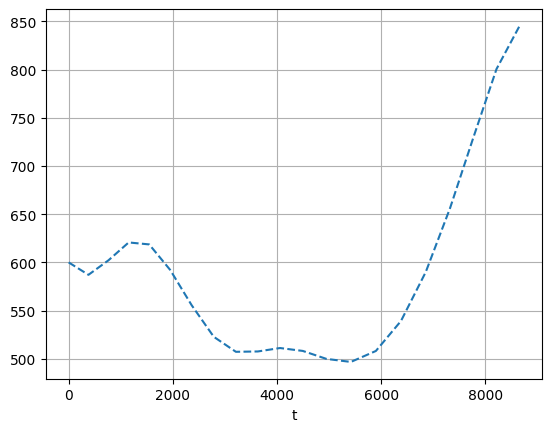

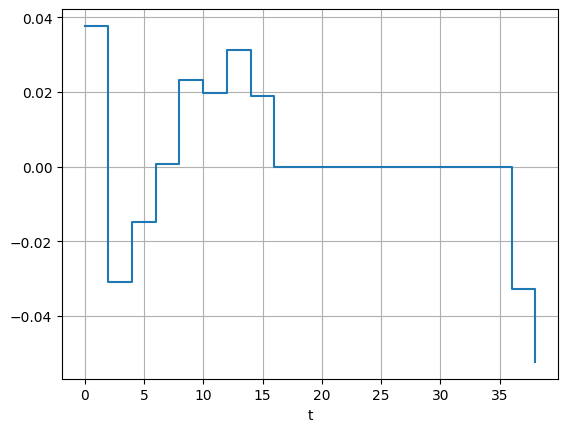

In [79]:
# Plot
# Result directly from IPOPT
x1_opt = w_opt[0::6]    # start at index 0, get every 6th:
x2_opt = w_opt[1::6]   
x3_opt = w_opt[2::6]  
x4_opt = w_opt[3::6] 
x5_opt = w_opt[4::6]
u_opt = w_opt[5::6]

tgrid = [params.tf/params.nu*k for k in range(params.nu+1)]

print("Optimal cost J* =", J_opt)
print(min(x2_opt))

plt.figure(1)
plt.clf()
plt.plot(x1_opt, x2_opt, '--')
plt.xlabel('t')
plt.grid()
plt.show()

plt.figure(2)
plt.clf()
plt.step(tgrid[:-1], u_opt, where='post')
plt.xlabel('t')
plt.grid()
plt.show()  


Optimal cost J* = 1.50021e+12
496.1471337054774


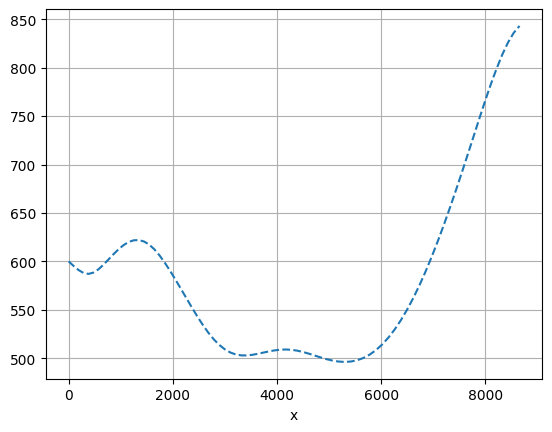

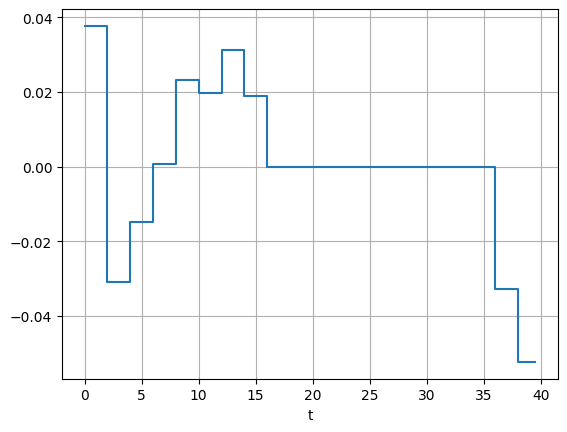

In [80]:


def reconstruction(u_opt, k_value, multipler):
    N = params.nu*multipler
    dt = params.tf/N
    
    # State, Time and Control
    x1 = MX.sym('x1')       # x
    x2 = MX.sym('x2')       # h
    x3 = MX.sym('x3')       # V
    x4 = MX.sym('x4')       # gamma
    x5 = MX.sym('x5')       # alpha
    t = MX.sym('t')         # time
    u = MX.sym('u')         # control
    x = vertcat(x1,x2,x3,x4,x5)   
    
    # Wind
    A1 = -50 + params.a * x1**3 + params.b * x1**4
    A2 = 0.025 * (x1 - 2300)
    A3 = 50 - params.a * (4600 - x1)**3 - params.b * (4600 - x1)**4
    A4 = 50 
    A = if_else(x1 <= 500, A1,
        if_else(x1 <= 4100, A2,
        if_else(x1 <= 4600, A3, A4)))
    A_piecewise = Function('A_piecewise', [x1], [A])
    
    B1 = params.d * x1**3 + params.e * x1**4
    B2 = -51 * exp(fmin(-params.c * (x1 - 2300)**4, 30))
    B3 = params.d * (4600 - x1)**3 + params.e * (4600 - x1)**4
    B4 = 0
    B = if_else(x1 <= 500, B1,
        if_else(x1 <= 4100, B2,
        if_else(x1 <= 4600, B3, B4)))
    B_piecewise = Function('B_piecewise', [x1], [B])
    
    wind_x_expr = k_value * A
    wind_x = Function('wind_x', [x1], [wind_x_expr])
    wind_h_expr = k_value * x2 * B / params.h_star
    wind_h = Function('wind_h', [x1, x2], [wind_h_expr])
    
    dWx_dx = Function("dWx_dx", [x1], [gradient(wind_x_expr, x1)])
    dWh_dx = Function("dWh_dx", [x1, x2], [gradient(wind_h_expr, x1)])
    dWh_dh = Function("dWh_dh", [x1, x2], [gradient(wind_h_expr, x2)])
    
    # Other functions
    C_L = if_else(x5 > params.alpha_star, params.C0 +params.C1 * x5, 
                       params.C0 + params.C1 * x5 + params.C2 * (x5 - params.alpha_star)**2)
    
    beta = if_else(t < params.sigma, 
                        params.beta0 + params.beta_dot0 * t, 1.0)
    
    T = beta * (params.A0 + params.A1 * x3 + params.A2 * x3**2)
    
    D = 0.5 * (params.B0 + params.B1 * x5 + params.B2 * x5**2) * params.rho * params.S * x3**2

    L = 0.5 * params.rho * params.S * C_L * x3**2
    
    # ode
    x1dot = x3 * cos(x4) + wind_x(x1)
    x2dot = x3 * sin(x4) + wind_h(x1,x2)
    
    wxdot = dWx_dx(x1) * x1dot
    whdot = dWh_dx(x1,x2) * x1dot + dWh_dh(x1,x2) * x2dot
    x3_safe = fmax(x3, 1e-3)
    
    x3dot = T / params.m * cos(x5 + params.delta) - D / params.m - params.g * sin(x4) - (wxdot * cos(x4) + whdot * sin(x4))
    x4dot = T / (params.m * x3) * sin(x5 + params.delta) + L / (params.m * x3) - params.g / x3_safe * cos(x4) + (1 / x3_safe) * (wxdot * sin(x4) - whdot * cos(x4))
    x5dot = u
    
    f = Function('f', [x, u, t], [vertcat(x1dot, x2dot, x3dot, x4dot, x5dot)])
    
    x2dotdot_expr = x3dot*sin(x4) + x3*x4dot*cos(x4) + whdot
    x2dotdot = Function('x2dotdot', [x, u, t], [x2dotdot_expr])
    
    # objective function
    Q = (params.hR-x2)**params.q
    qf = Function('qf', [x], [Q])
    
    # Integration
    def rk4_step(xk, uk, tk, dt, qk):
        k1 = f(xk, uk, tk)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
        k4 = f(xk + dt * k3, uk, tk + dt)
        qk1 = qf(xk)
        qk2 = qf(xk + dt/2 * k1)
        qk3 = qf(xk + dt/2 * k2)
        qk4 = qf(xk + dt * k3)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4), qk + dt/6 * (qk1 + 2*qk2 + 2*qk3 + qk4)
    
    # Prep
    U = []
    for k in range(params.nu):
        for i in range(multipler):
            U.append(u_opt[k])
            
    X = [] 
    J = 0  
    
    # initial condition
    Xk = [0, 600, 239.7, -2.249*pi/180, 7.353*pi/180]
    X.extend(Xk)
    Tk = 0
    
    for k in range(N):
        Xk, J = rk4_step(Xk, U[k], Tk, dt, J)
        Tk += dt
        X.extend(Xk.full().flatten())
    
    T = [params.tf/N*k for k in range(N+1)]
    
    return X,J,U,T

# Plot
X, J, U, T = reconstruction(u_opt, set_k, 4)


x1_opt = X[0::5]    # start at index 0, get every 6th:
x2_opt = X[1::5]   
x3_opt = X[2::5]  
x4_opt = X[3::5] 
x5_opt = X[4::5]


print("Optimal cost J* =", J)
print(min(x2_opt))

plt.figure(1)
plt.clf()
plt.plot(x1_opt, x2_opt, '--')
plt.xlabel('x')
plt.grid()
plt.show()

plt.figure(2)
plt.clf()
plt.step(T[:-1], U, where='post')
plt.xlabel('t')
plt.grid()
plt.show()  

